#### Draw R2 across ROI and attention condition

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.express as px
from plot_utils import plotly_template

# Define parameters
subjects = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
            'sub-005', 'sub-006', 'sub-007', 'sub-008']
subjects_plot = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
                 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'group']
rois = ['V1', 'V2', 'V3', 'V3AB', 'hMT+', 'LO',
        'VO', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)

# settings
n_ecc_bins = 10
best_voxels_num = 250

# General figure settings
template_specs = dict(  axes_color="rgba(0, 0, 0, 1)",
                        axes_width=2,
                        axes_font_size=13,
                        bg_col="rgba(255, 255, 255, 1)",
                        font='Arial',
                        title_font_size=15,
                        plot_width=1.5)
fig_template = plotly_template(template_specs)

- [x] organize data
- [x] make bar plot
- [ ] do stats against zero
- [ ] do stats attend-fix vs attend-bar

In [3]:
# load TSV
for subject_num, subject in enumerate(subjects):
    tsv_dir = '{}/{}/prf/tsv'.format(pp_dir, subject)
    df_fn = "{}/{}_refit_res_best{}.pkl".format(tsv_dir,subject,int(best_voxels_num))
    df_sub = pd.read_pickle(df_fn)
    
    # create new df
    df_new = pd.DataFrame({'subject': df_sub.subject}) 
    df_new['roi'] = df_sub.roi
    df_new['af_ref_index'] = df_sub.af_ref_index
    df_new['ab_ref_index'] = df_sub.ab_ref_index
    
    # across roi
    if subject_num > 0: df = pd.concat([df,df_new], ignore_index=True)
    else: df = df_new

df.roi = pd.Categorical(df.roi,categories=rois)

In [20]:
# Subplot settings
margin_t, margin_b, margin_l, margin_r = 50, 100, 100 ,50
rows, cols = 1, 1

column_widths,row_heights = [1], [1]
sb_specs = [[{}]]
subplot_width, subplot_height = 350,700

fig_width, fig_height = 0, 0
for column_width in column_widths:fig_width += subplot_width*column_width
for row_height in row_heights: fig_height +=subplot_height*row_height
fig_width = fig_width + margin_l + margin_r
fig_height = fig_height + margin_t + margin_b

xaxis_range = [-.6, .6]
xaxis_tick = 5
xaxis_tickvals = np.linspace(xaxis_range[0],xaxis_range[1],xaxis_tick)
xaxis_title = 'Reference frame<br>index (a.u.)'
xaxis_ticktext = []
[xaxis_ticktext.append(('{:g}'.format(val))) for val in xaxis_tickvals]

x_gap_line = 0.1*xaxis_range[1]
x_gap_asterisk = 0.15*xaxis_range[1]

ab_col = "rgba(0, 0, 0, 1)"
af_col = "rgba(157, 157, 157, 1)"

hover_temp = 'ROI: %{y}<br>' + 'Ref. index: %{x:1.2f}'

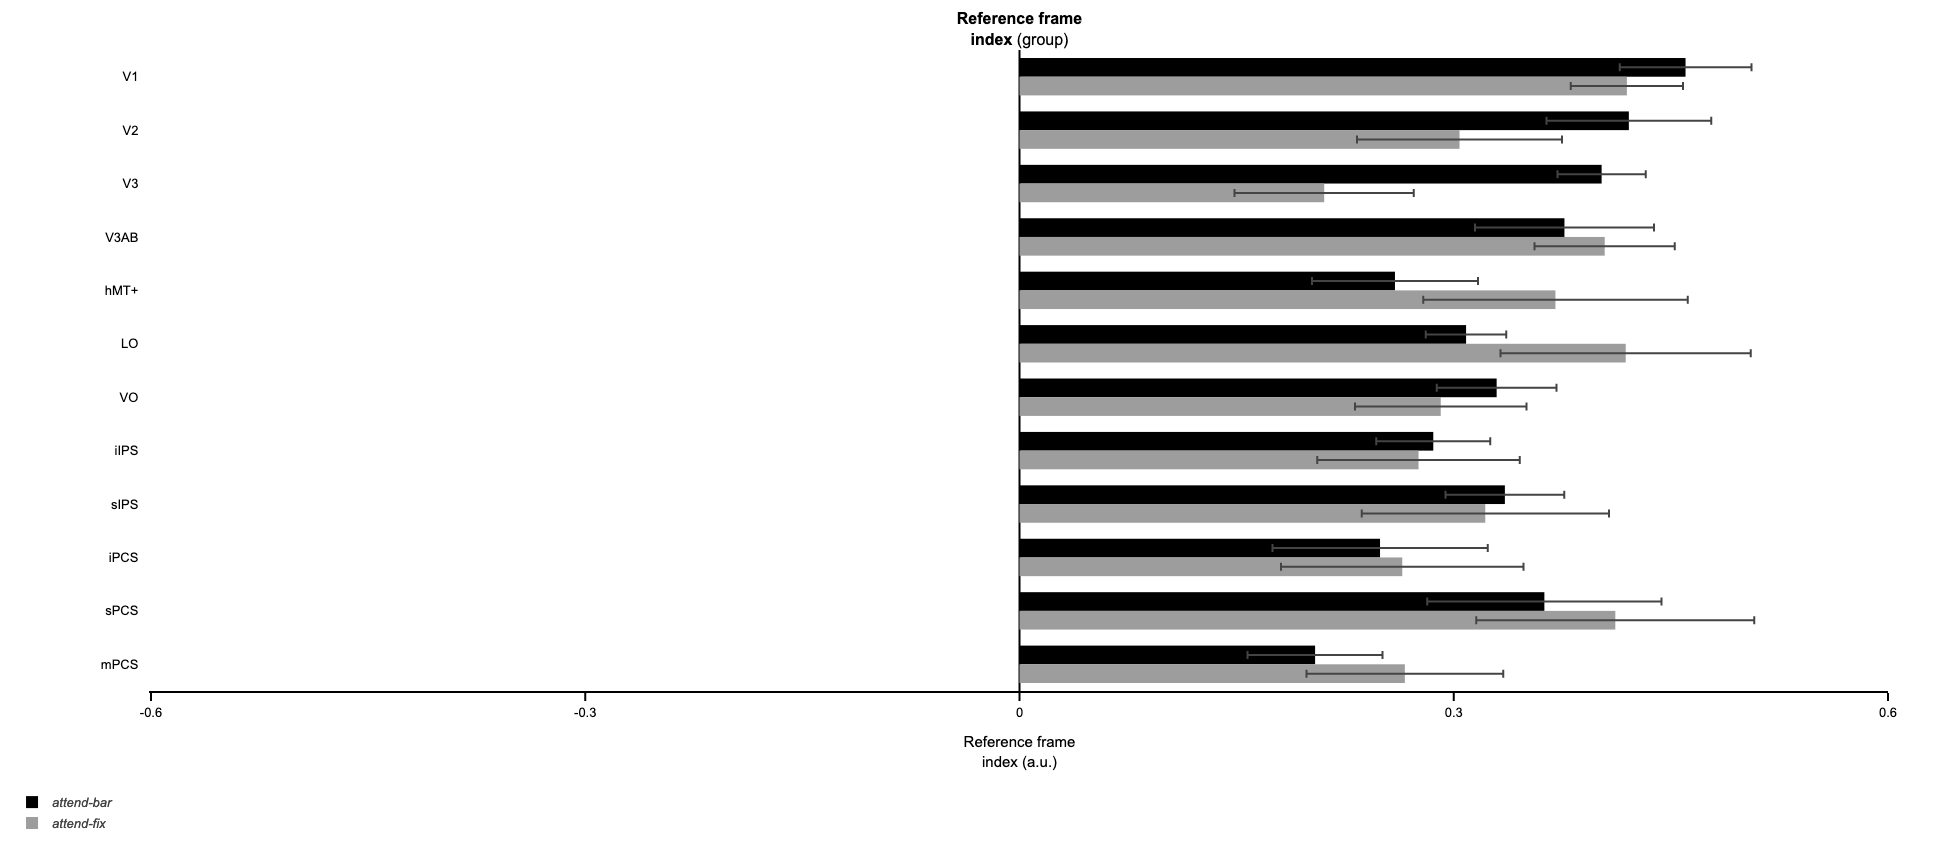

In [21]:
# Subplot settings

#for subject in subjects_plot:
for subject in ['group']:
    subplot_titles = ['<b>Reference frame<br>index</b> ({})'.format(subject)]
    
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.15, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)
 
    # get data
    if subject == 'group': 
        x_af = df.groupby(['subject','roi']).af_ref_index.mean().reset_index(name='af_ref_index_mean').groupby('roi').af_ref_index_mean.mean()
        x_ab = df.groupby(['subject','roi']).ab_ref_index.mean().reset_index(name='ab_ref_index_mean').groupby('roi').ab_ref_index_mean.mean()
        x_af_eb = df.groupby(['subject','roi']).af_ref_index.mean().reset_index(name='af_ref_index_mean').groupby('roi').af_ref_index_mean.sem(ddof=-1)
        x_ab_eb = df.groupby(['subject','roi']).ab_ref_index.mean().reset_index(name='ab_ref_index_mean').groupby('roi').ab_ref_index_mean.sem(ddof=-1)
    else:
        x_af = df.loc[(df.subject==subject)].groupby('roi').af_ref_index.mean()
        x_ab = df.loc[(df.subject==subject)].groupby('roi').ab_ref_index.mean()
        x_af_eb = df.loc[(df.subject==subject)].groupby('roi').af_ref_index.std()
        x_ab_eb = df.loc[(df.subject==subject)].groupby('roi').ab_ref_index.std()
        
    # bar plot
    fig.append_trace(go.Bar(y=rois, x=x_ab, orientation='h', marker_color=ab_col, hovertemplate=hover_temp,
                            showlegend=True, legendgroup='attend-bar', name='<i>attend-bar<i>',
                            error_x_type='data', error_x_symmetric=False, error_x_array=x_ab_eb, error_x_arrayminus=x_ab_eb),row=1, col=1)

    fig.append_trace(go.Bar(y=rois, x=x_af, orientation='h', marker_color=af_col, hovertemplate=hover_temp,
                            showlegend=True, legendgroup='attend-fix', name='<i>attend-fix<i>', 
                            error_x_type='data', error_x_symmetric=False, error_x_array=x_af_eb, error_x_arrayminus=x_af_eb),row=1, col=1)

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1, autorange='reversed')

    # set figure axis
    for xaxis in ['xaxis']:
        exec("fig.layout.update({}_range=xaxis_range)".format(xaxis))
        exec("fig.layout.update({}_title=xaxis_title)".format(xaxis))
        exec("fig.layout.update({}_tickvals=xaxis_tickvals)".format(xaxis))
        exec("fig.layout.update({}_ticktext=xaxis_ticktext)".format(xaxis))
        exec("fig.layout.update({}_zeroline=True)".format(xaxis))
        
    # set figure
    fig.layout.update(yaxis_title='', yaxis_color = 'rgba(0,0,0,0)', yaxis_tickfont_color='black', bargap=0.30, template=fig_template, width=fig_width, height=fig_height, margin_l=margin_l, margin_r=margin_r, margin_t=margin_t, margin_b=margin_b,
                      legend_yanchor='top', legend_y=-0.15,legend_x=-0.08, legend_xanchor='left', legend_bgcolor='rgba(255,255,255,0)', legend_tracegroupgap=1)
    
    # show and save figure
    fig.show(config={"displayModeBar": False})
    #fig.write_image("{}/{}_attcmp{}.pdf".format(tsv_dir, subject, type_analysis))
    #fig.write_html("{}/{}_attcmp{}.html".format(tsv_dir, subject, type_analysis),config={"displayModeBar": False})